In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

## CPS Data

In [2]:
df = pd.read_csv('CPS.csv',sep=';')
Y_true_full = np.reshape(df['log_wage'].values, (40,-1))
Y_true_full = Y_true_full.T
Y_true_full /= np.std(Y_true_full)
Y_true_full -= np.mean(Y_true_full)
N_total,T_total = Y_true_full.shape

In [3]:
df

,state,year,log_wage,hours,urate,min_wage,open_carry,abort_ban
0,AK,1979,-0.759183,37.504,0.073,False,False,False
1,AL,1979,-2.269627,36.289,0.065,False,False,False
2,AR,1979,-2.225654,37.182,0.060,False,False,False
3,AZ,1979,-1.724803,38.692,0.045,False,False,False
4,CA,1979,-1.651739,36.578,0.060,False,False,False
...,...,...,...,...,...,...,...,...
1995,VT,2018,1.676063,38.760,0.027,True,True,True
1996,WA,2018,1.702448,36.485,0.033,True,False,True
1997,WI,2018,1.311645,35.916,0.009,False,True,False
1998,WV,2018,1.264739,36.563,0.055,False,True,False


In [4]:
Y_true_full.shape

(50, 40)

## TWFE Regression with 1 Factor to Extract Unit Loadings

In [5]:
def TWFE_one_factor(Y, M, iters=100):
    units, times = Y.shape
    
    time_factors = np.ones((1,times))

    # polishing effect of OSQP results in not truly weighting by zero; use cp.sum_squares instead of
    #objective = cp.sum(cp.multiply(cp.square(Y-unit_factor-time_factor),W))
    
    # iterate between updating unit and time loadings
    for i in range(iters):
        
        unit_effect = cp.Variable((1,units))
        time_effect = cp.Variable((1,times))
        unit_effects = cp.kron(np.ones((times,1)),unit_effect).T
        time_effects = cp.kron(np.ones((units,1)),time_effect)
        mu = cp.Variable()
        
        unit_loadings = cp.Variable((units,1))
    
        
        objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects-mu-unit_loadings@time_factors,M))

        constraints = [cp.sum(unit_loadings)==1]

        prob = cp.Problem(cp.Minimize(objective),
                          constraints)
        prob.solve()
        unit_loadings = unit_loadings.value    
        
        print(unit_loadings[0])
                
        unit_effect = cp.Variable((1,units))
        time_effect = cp.Variable((1,times))
        unit_effects = cp.kron(np.ones((times,1)),unit_effect).T
        time_effects = cp.kron(np.ones((units,1)),time_effect)
        mu = cp.Variable()
        
        time_factors = cp.Variable((1,times))
        
        objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects-mu-unit_loadings@time_factors,M))

        constraints = []

        prob = cp.Problem(cp.Minimize(objective),
                          constraints)
        prob.solve()
        time_factors = time_factors.value
                
    return unit_loadings, time_factors, unit_effect.value.T+time_effect.value+mu.value+unit_loadings.dot(time_factors)

In [6]:
#mask = np.ones(Y_true_full.shape)
np.random.seed(0)
mask = np.random.binomial(1, 0.5, size=(Y_true_full.shape))

In [7]:
unit_loadings, time_factors, predicted_values = TWFE_one_factor(Y_true_full, mask)
unit_loadings

[0.28789037]
[0.55383645]
[0.64585241]
[0.65851316]
[0.64546148]
[0.63326066]
[0.62626565]
[0.62279953]
[0.62112137]
[0.6202977]
[0.61988432]
[0.61967231]
[0.61956161]
[0.61950302]
[0.6194717]
[0.61945486]
[0.61944575]
[0.61944082]
[0.61943814]
[0.61943668]
[0.61943589]
[0.61943546]
[0.61943523]
[0.6194351]
[0.61943503]
[0.61943499]
[0.61943497]
[0.61943496]
[0.61943495]
[0.61943495]
[0.61943495]
[0.61943495]
[0.61943495]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0.61943494]
[0

array([[ 0.61943494],
       [-0.03705265],
       [-0.02615279],
       [ 0.13744655],
       [ 0.19065218],
       [-0.07478141],
       [-0.08260291],
       [-0.15252073],
       [ 0.07342575],
       [-0.0217705 ],
       [ 0.15511542],
       [-0.12294734],
       [ 0.00594126],
       [ 0.06289434],
       [ 0.04285772],
       [ 0.12420469],
       [-0.01671652],
       [ 0.12159217],
       [-0.17964059],
       [-0.07359269],
       [-0.13888735],
       [ 0.03501847],
       [-0.17247295],
       [-0.02317508],
       [-0.00448344],
       [ 0.11494614],
       [ 0.03136052],
       [-0.06796681],
       [-0.18929829],
       [-0.12916432],
       [-0.09669748],
       [ 0.1861139 ],
       [ 0.27674117],
       [ 0.02662609],
       [ 0.06331001],
       [ 0.29658048],
       [ 0.14026969],
       [-0.05013647],
       [-0.12314725],
       [-0.03227444],
       [-0.21613691],
       [ 0.09190785],
       [ 0.19491839],
       [ 0.19371807],
       [-0.01358233],
       [-0

In [8]:
np.sum(unit_loadings)

1.0000000000000002

## Bias of DID

In [14]:
np.random.seed(0)
biases = []
coefficients = np.arange(-5,5,0.1)
for coefficient in coefficients:
    
    bias = []
    
    for experiment in range(10000):
        treat_prob = 1 / (1 + np.exp(-unit_loadings*coefficient))
        treat_vec = np.random.binomial(1, treat_prob)
        eta_1 = np.mean(unit_loadings[treat_vec==1])
        eta_0 = np.mean(unit_loadings[treat_vec==0])
    
        lambda_1 = np.mean(time_factors[:,-20:])
        lambda_0 = np.mean(time_factors[:,:-20])
        
        bias.append(((eta_1-eta_0)*(lambda_1-lambda_0)))
        
    biases.append(np.abs(np.mean(bias)))

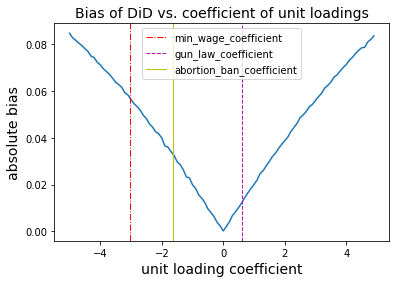

In [22]:
plt.plot(coefficients,biases)
plt.title('Bias of DiD vs. coefficient of unit loadings',fontsize=14)
plt.axvline(x=-3.02, color='r', linestyle='-.', linewidth=1, label='min_wage_coefficient')
plt.axvline(x=0.61, color='m', linestyle='--', linewidth=1, label='gun_law_coefficient')
plt.axvline(x=-1.63, color='y', linestyle='-', linewidth=1, label='abortion_ban_coefficient')
plt.xlabel('unit loading coefficient',fontsize=14)
plt.ylabel('absolute bias',fontsize=14)
plt.legend()
plt.savefig("bias_DiD.pdf", format='pdf')

plt.show()
